In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
import requests
from spacy import displacy
import bs4
import networkx as nx
from tqdm import tqdm
from spacy.matcher import Matcher
from spacy.tokens import Span
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [31]:
nlp = spacy.load('en_core_web_sm')

In [32]:
candidate_sentences = pd.read_csv('/content/drive/MyDrive/Knowledge Graphs/wiki_sentences_v2.csv')
candidate_sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [33]:
candidate_sentences.shape

(4318, 1)

In [34]:
candidate_sentences.sample(5)

,sentence
2053,ii helped fox overtake rko and metro-goldwyn-mayer to become the third most profitable film studio.
1001,"a few silent charlie chan films, now lost, were produced in the 1920s."
4098,it is the first nickelodeon film to be nominated for an academy award.
1096,xavier's college in mumbai but dropped out.
3290,"it is also the widest r-rated imax release, across 381 imax theaters."


In [35]:
candidate_sentences['sentence'][0]

'confused and frustrated, connie decides to leave on her own.'

In [36]:
doc = nlp(candidate_sentences['sentence'][0])
for tok in doc:
  print(tok.text,"... ",tok.dep_)

confused ...  advcl
and ...  cc
frustrated ...  conj
, ...  punct
connie ...  nsubj
decides ...  ROOT
to ...  aux
leave ...  xcomp
on ...  prep
her ...  poss
own ...  pobj
. ...  punct


In [ ]:
displacy.serve(nlp("The team is not performing well in the match"),style='dep')


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...



## Entity-Pairs extraction

In [37]:
  def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = "" # dependency tag for previous token in the sentence.
    prv_tok_text = "" # previous token in the sentence.

    prefix = ""
    modifier = ""

    ## chunk 2

    for tok in nlp(sent):
      if tok.dep_ !="punct": # Check token is a punctuation or not.
        if tok.dep_ == "compound": # Check token is a compound word or not.
          prefix = tok.text
          if prv_tok_dep == "compound": # Add compunds together.
            prefix = prv_tok_text + " " + tok.text

        if tok.dep_.endswith("mod") == True:
          modifier = tok.text
          if prv_tok_dep == "compound":
            modifier = prv_tok_text + " " + tok.text

    ## chunk 3

        if tok.dep_.find("subj") == True:
          ent1 = modifier + " " + prefix + " " + tok.text
          prefix = ""
          modifier = ""
          prv_tok_dep = ""
          prv_tok_text = ""
    
    ## chunk 4
        
        if tok.dep_.find("obj") == True:
          ent2 = modifier + " " + prefix + " " + tok.text

    ## chunk 5

        prv_tok_text = tok.text
        prv_tok_dep = tok.dep_
    return [ent1.strip(),ent2.strip()]

In [38]:
get_entities("The film won 20 oscars")

['film', '20  oscars']

In [39]:
entity_pairs = []

for i in tqdm(candidate_sentences['sentence']):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:47<00:00, 91.05it/s]


In [40]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

## Relation Extraction

In [41]:
def get_relation(sent):
  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'},
             {'DEP':'prep','OP':'?'},
             {'DEP':'agent','OP':'?'},
             {'POS':'ADJ','OP':'?'}
             ]
  matcher.add("matching_1",None,pattern)

  matches = matcher(doc)
  k = len(matches)-1

  span = doc[matches[k][1]:matches[k][2]]
  return (span.text)

In [42]:
get_relation('John is a good boy')

'is'

In [43]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:45<00:00, 94.70it/s]


In [44]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
became            31
has               31
become            29
released in       27
included          26
produced          22
called            22
considered        20
had               20
made              20
been              18
be                18
scheduled         17
used              17
directed by       16
stars             16
written by        15
produced by       14
wrote             14
set               14
hired             14
received          13
went              13
introduced in     13
wanted            12
began in          11
began             11
won               11
sold              10
features          10
gave              10
shot in            9
produced in        9
directed           9
opened             9
known as           9
reported           9
used in      

## Constructing Knowledge Graphs

In [45]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

df = pd.DataFrame({'source':source,'target':target,'edge':relations})
df.sample(5)

,source,target,edge
957,today drawings,directly computer system,scanned into
1463,21st century,assamese bollywood movies,produced
2562,she,,call
3077,he,it,see
2162,it,sister adweek,is


In [46]:
G = nx.from_pandas_edgelist(df,"source","target",edge_attr=True,create_using=nx.MultiDiGraph())

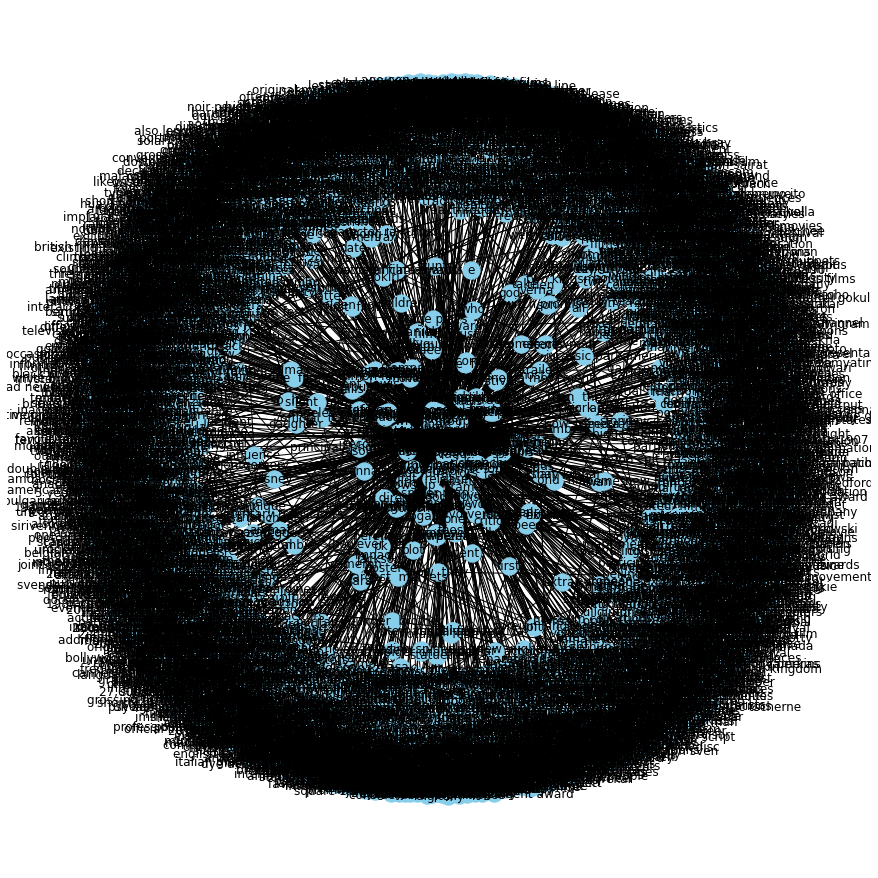

In [47]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
plt.show()

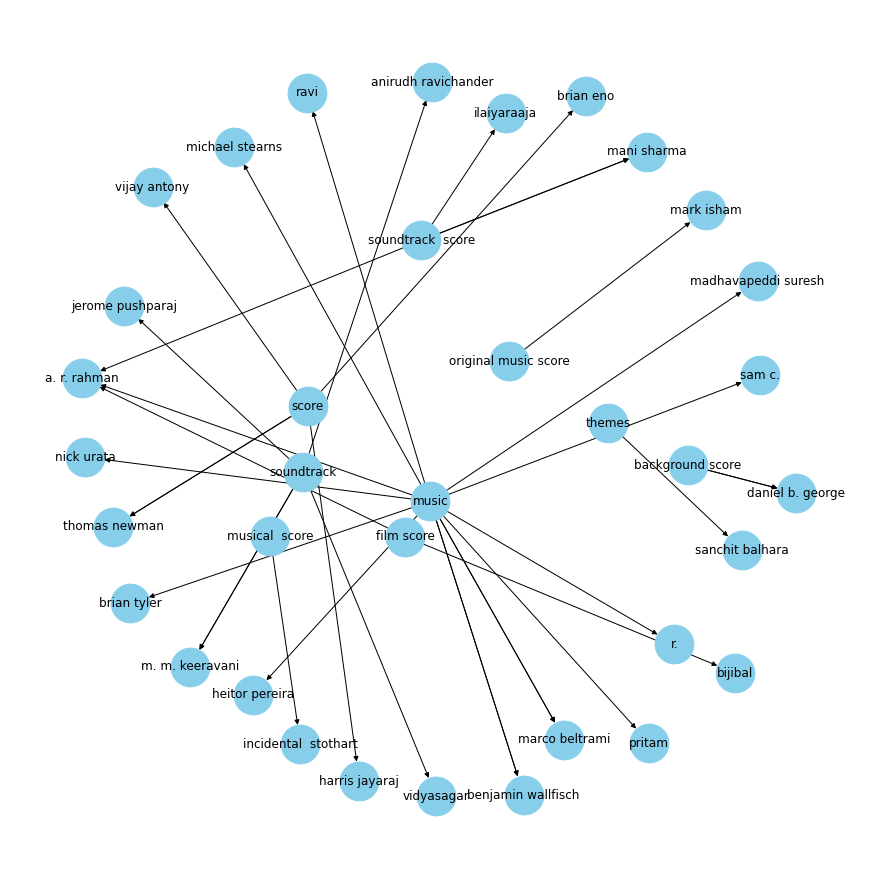

In [49]:
G=nx.from_pandas_edgelist(df[df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph()) # Consider only a single relation "Composed by"

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

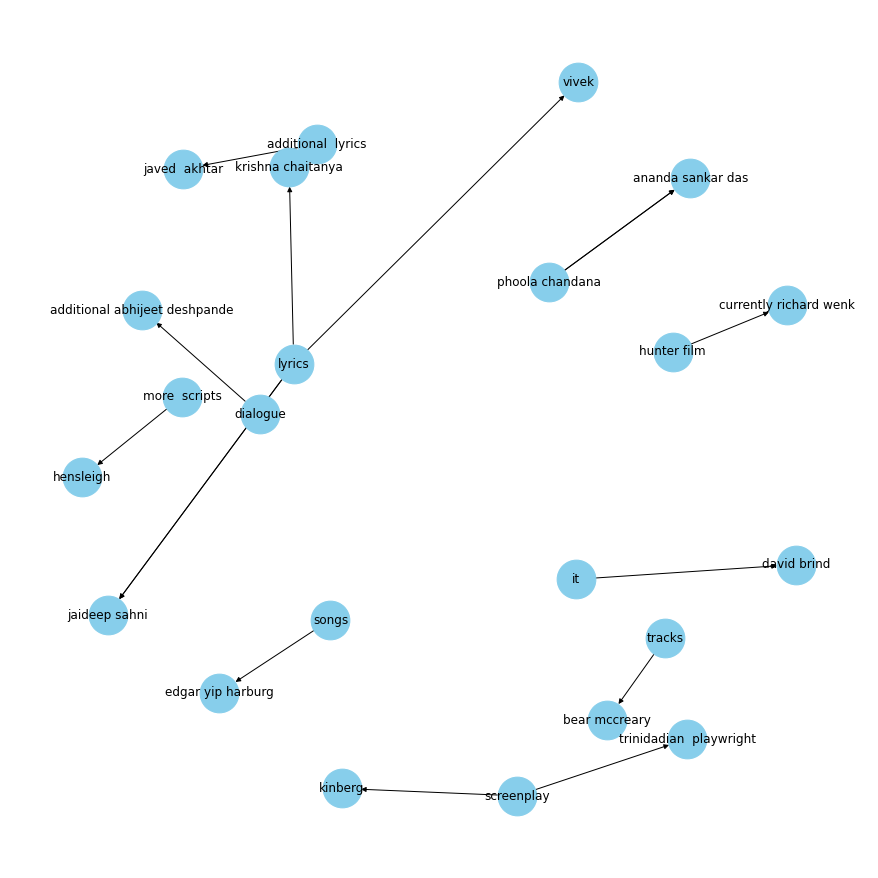

In [50]:
G=nx.from_pandas_edgelist(df[df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph()) # Consider only a single relation "written by"

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

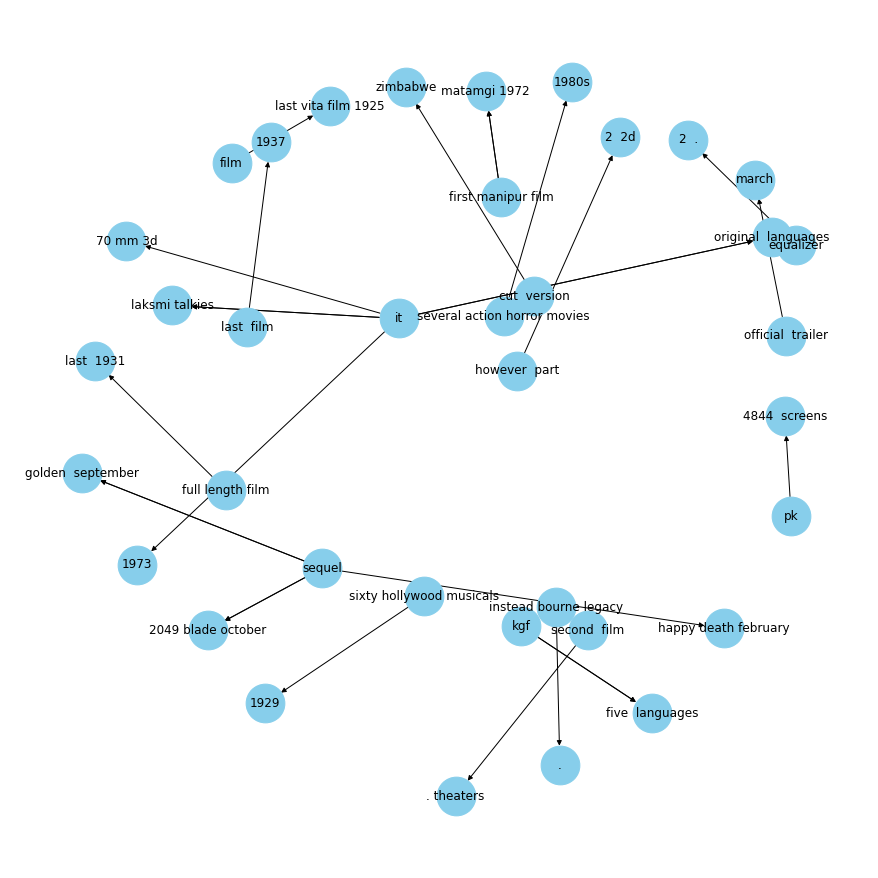

In [51]:
G=nx.from_pandas_edgelist(df[df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph()) # Consider only a single relation "released in"

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()